# Regresión logística

La regresión logística es una variante de los modelos lineales en los que el valor que se predice se acota entre 0 y 1, representando la probabilidad de que ocurra un evento, por lo que se aplica a lo que se denomina *clasificación binaria*. La ecuación general de los modelos lineales se modifica así:

## $\log \frac{p}{1 - p} = b_0 + b_1 x_1 + b_2 x_2 + \cdots + b_n x_n$

donde ahora $p$ representa la probabilidad de que ocurra el evento que se estudia (por ejemplo, que un paciente al que se le hace un análisis de sangre tenga un tumor maligno o no). Cuando se hace una predicción usando un modelo de regresión logística sobre nuevos datos, se obtiene un número entre 0 y 1 que se suele denominar *score*. Si supera cierto valor umbral (denominado también *punto de corte*) entonces se considera que se va a producir el evento. Por tanto, no solo hay que entrenar el modelo, además hay que elegir un valor umbral que sea óptimo. Para ello se utilizan las curvas ROC (Receiver Operating Characteristic).

Comenzamos como siempre, cargando las librerías que vamos a necesitar y configurando el entorno:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg' 

Subimos el archivo de datos a Colab y lo cargamos en memoria, especificando que PassengerId se tomará como índice:

In [2]:
##### DOWNLOAD DATASET. ONLY IN COLAB !!!
!wget -P ./../data/ https://raw.githubusercontent.com/CenticMurcia/curso-ciencia-datos/master/data/titanic_train.csv

--2020-02-10 20:05:20--  https://raw.githubusercontent.com/CenticMurcia/curso-ciencia-datos/master/data/titanic_train.csv
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.128.133, 151.101.64.133, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[151.101.192.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 61194 (60K) [text/plain]
Guardando como: “./../data/titanic_train.csv.9”

titanic_train.csv.9 100%[===================>]  59,76K  --.-KB/s    en 0,09s   

2020-02-10 20:05:21 (692 KB/s) - “./../data/titanic_train.csv.9” guardado [61194/61194]



In [2]:
train_df = pd.read_csv("../data/titanic_train.csv", index_col='PassengerId') 

Echamos un vistazo a los datos y hacemos una breve descripción estadística, primero de las variables cuantitativas y luego de las cualitativas

In [3]:
train_df.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_df.describe(include=['object', 'bool'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Foo, Mr. Choong",male,347082,C23 C25 C27,S
freq,1,577,7,4,644


Vemos que hay un total de 891 pasajeros, pero solo tenemos la edad de 714. Y solo conocemos el camarote (Cabin) de 204 y el puerto de embarque (Embarked) de 889. También vemos que hay algunas variables que no parecen contener ninguna información: el nombre del pasajero (Name), el número de ticket (Ticket) y el número de camarote (Cabin). Por tanto haremos varias cosas para limpiar el dataset:

- Eliminar las variables (columnas) Name, Ticket, y Cabin
- Eliminar los casos (filas) en los que no estén especificados la edad y/o el puerto de embarque

In [7]:
train_df = train_df.drop(['Name', 'Ticket', 'Cabin'], axis=1).dropna()

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Sex       712 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Fare      712 non-null    float64
 7   Embarked  712 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 50.1+ KB


Nos hemos quedado con un dataset cuadrado de 712 filas y 8 columnas, sin columnas que carezcan de información ni casos con valores perdidos. Ahora recodificaremos con la técnica one-hot la variable Embarked. Más adelante, cuando expliquemos los resultados del modelo, veremos el por qué.

In [9]:
# One-hot-encoding para Embarked
one_hot = pd.get_dummies(train_df['Embarked'])
train_df = train_df.drop('Embarked', axis = 1)
train_df = train_df.join(one_hot)

Para la variable Sexo vamos a definir que los hombres serán 1 y las mujeres 0. De nuevo, la utilidad de esto la veremos más adelante.

In [10]:
train_df.Sex.value_counts()

male      453
female    259
Name: Sex, dtype: int64

In [11]:
from sklearn import preprocessing 

label_encoder = preprocessing.LabelEncoder() 
train_df['Sex']= label_encoder.fit_transform(train_df['Sex']) 

Ahora hemos eliminado la columnna Embarked, sustituyéndola por tres columnas: C (Cherbourg), Q (Queenstown) y S (Southampton). Para el sexo, tenemos ahora que male=1 y female=0. Con el one-hot-encoding nunca habrá un caso en el que C sea 1 y Q o S sean también 1, ni ninguna otra combinación. Solo una de las tres puede ser 1. Esta transformación nos permite incluir variables cualitativas en los modelos lineales.

In [12]:
train_df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.404494,2.240169,0.636236,29.642093,0.514045,0.432584,34.567251,0.182584,0.039326,0.778090
std,0.491139,0.836854,0.481420,14.492933,0.930692,0.854181,52.938648,0.386597,0.194506,0.415823
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.000000,0.000000,0.000000,8.050000,0.000000,0.000000,1.000000
50%,0.000000,2.000000,1.000000,28.000000,0.000000,0.000000,15.645850,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,1.000000,33.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,5.000000,6.000000,512.329200,1.000000,1.000000,1.000000


Definimos ahora las variables de entrenamiento (X) y la variable a predecir (Y)

In [13]:
y = train_df['Survived']
x = train_df.drop(['Survived'], axis=1)

In [14]:
y.describe()

count    712.000000
mean       0.404494
std        0.491139
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

In [15]:
x.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,2.240169,0.636236,29.642093,0.514045,0.432584,34.567251,0.182584,0.039326,0.778090
std,0.836854,0.481420,14.492933,0.930692,0.854181,52.938648,0.386597,0.194506,0.415823
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,20.000000,0.000000,0.000000,8.050000,0.000000,0.000000,1.000000
50%,2.000000,1.000000,28.000000,0.000000,0.000000,15.645850,0.000000,0.000000,1.000000
75%,3.000000,1.000000,38.000000,1.000000,1.000000,33.000000,0.000000,0.000000,1.000000
max,3.000000,1.000000,80.000000,5.000000,6.000000,512.329200,1.000000,1.000000,1.000000


Dividimos el dataset en subconjuntos de entrenamiento (80%) y de validación (20%), estratificando según la supervivencia del pasajero:

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify = y, random_state=4)

In [18]:
x_train.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
count,569.000000,569.000000,569.00000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,2.223199,0.625659,29.54877,0.497364,0.472759,34.105594,0.179262,0.036907,0.783831
std,0.837768,0.484378,14.35011,0.929037,0.907546,48.595484,0.383909,0.188699,0.411993
min,1.000000,0.000000,0.42000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,20.00000,0.000000,0.000000,8.050000,0.000000,0.000000,1.000000
50%,2.000000,1.000000,28.00000,0.000000,0.000000,15.850000,0.000000,0.000000,1.000000
75%,3.000000,1.000000,39.00000,1.000000,1.000000,34.375000,0.000000,0.000000,1.000000
max,3.000000,1.000000,74.00000,5.000000,6.000000,512.329200,1.000000,1.000000,1.000000


In [19]:
x_test.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,2.307692,0.678322,30.013427,0.580420,0.272727,36.404195,0.195804,0.048951,0.755245
std,0.832701,0.468762,15.093983,0.937577,0.571406,67.689748,0.398213,0.216524,0.431453
min,1.000000,0.000000,0.920000,0.000000,0.000000,4.012500,0.000000,0.000000,0.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.987500,0.000000,0.000000,1.000000
50%,3.000000,1.000000,28.000000,0.000000,0.000000,13.500000,0.000000,0.000000,1.000000
75%,3.000000,1.000000,37.500000,1.000000,0.000000,30.035400,0.000000,0.000000,1.000000
max,3.000000,1.000000,80.000000,4.000000,2.000000,512.329200,1.000000,1.000000,1.000000


In [20]:
y_train.describe()

count    569.000000
mean       0.404218
std        0.491172
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

In [21]:
y_test.describe()

count    143.000000
mean       0.405594
std        0.492733
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

Ya podemos crear el modelo de regresión logística:

In [23]:
from sklearn.linear_model import LogisticRegression

# check classification scores of logistic regression
logreg = LogisticRegression(max_iter=2000, random_state=1)
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Ahora para cada pasajero tenemos tanto la predicción como una probabilidad de que sobreviva. Podemos representar la matriz de confusión y cómo se relacionan estas probabilidades con el verdadero valor de Survived, tanto para el entrenamiento como para la validación:

In [24]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, plot_confusion_matrix
import seaborn as sns

Accuracy: 80.4920913884007
Balanced accuracy:  79.08490445042965


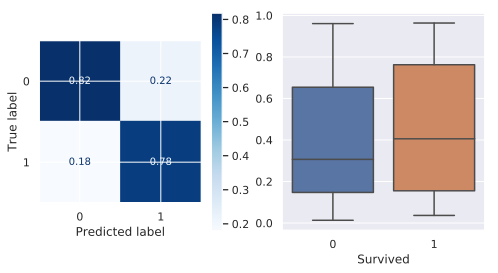

In [25]:
# Para el entrenamiento
y_pred = logreg.predict(x_train)
y_pred_proba = logreg.predict_proba(x_train)[:, 1]

print("Accuracy:", accuracy_score(y_train, y_pred)*100)
print("Balanced accuracy: ", balanced_accuracy_score(y_train, y_pred)*100)

_, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_confusion_matrix(logreg, x_train, y_train,
                      cmap=plt.cm.Blues, normalize="pred",
                      ax=axes[0]);

g = sns.boxplot(x = y_train, y = y_pred_proba, ax=axes[1])

Vemos que la precisión ponderada del modelo (balanced accuracy) es razonablemente buena (79.1%), aunque no demasiado: como la proporción de fallecidos es del 59.6% (424 / 712) si decimos sin analizar ningún dato que el pasajero se ahoga tenemos una probabilidad basal del 59.6% de acertar. Vemos en el gráfico de cajas que la distribución de *scores* es muy parecida entre los que se ahogan y los que no. Cuando los modelos son muy buenos las cajas están muy separadas. No es el caso aquí.

Apliquemos ahora el modelo al conjunto de validación:

Accuracy: 79.72027972027972
Balanced accuracy:  77.46450304259636


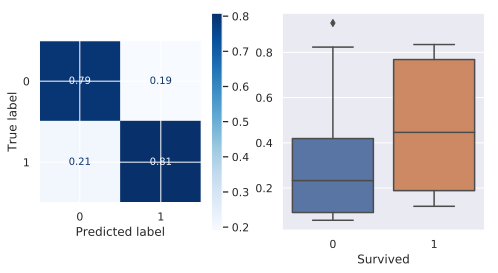

In [26]:
# Para la validación
y_pred = logreg.predict(x_test)
y_pred_proba = logreg.predict_proba(x_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred)*100)
print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred)*100)

_, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_confusion_matrix(logreg, x_test, y_test,
                      cmap=plt.cm.Blues, normalize="pred",
                      ax=axes[0]);

g = sns.boxplot(x = y_test, y = y_pred_proba, ax=axes[1])

Los resultados son parecidos a los del conjunto de entrenamiento. Tenemos una balanced accuracy algo menor, del 77.5%, y la distribución de scores entre grupos es también muy parecida y no demasiado buena. Ojo, aún no hemos estudiado el punto de corte óptimo para separar los dos grupos, lo que haremos usando la curva ROC:

Train/Test split results:
LogisticRegression accuracy is 0.797
LogisticRegression log_loss is 0.447
LogisticRegression auc is 0.861


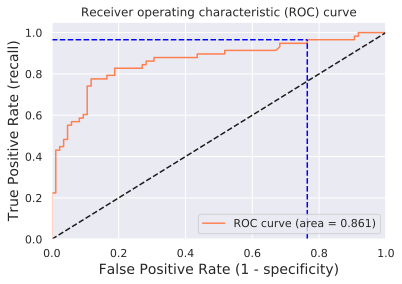

Using a threshold of 0.083 guarantees a sensitivity of 0.966 and a specificity of 0.235, i.e. a false positive rate of 76.47%.


In [27]:
from sklearn.metrics import roc_curve, accuracy_score, log_loss, auc

[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))


El principal parámetro de calidad de una curva ROC es el área bajo la curva (AUC, Area Under Curve), que en este caso es 0.861. Su valor oscila entre 0.5 (modelo no informativo) y 1 (modelo perfecto), por lo que nuestro modelo es razonablemente bueno, aunque nada del otro mundo. En la gráfica se nos indica que el punto de corte óptimo es 0.083, una cifra bastante baja: todos los pasajeros que tengan una probabilidad mayor se clasifican como supervivientes, el resto como ahogados.

Existen muchas maneras de definir la calidad de un modelo, habiendo multitud de índices cada uno con sus ventajas e inconvenientes. Para saber más sobre ellos se puede consultar por ejemplo este link:
https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/

Ya hemos visto que el AUC es razonablemente alto, y la sensibilidad también lo es (0.966), pero resulta curioso que la especificidad sea tan baja (0.235). Probablemente indica que el modelo tiende a predecir que el pasajero va a ahogarse, y luego va afinando la predicción.

Aunque el modelo no es muy bueno, tenemos ahora la ventaja de que podemos determinar cómo afecta cada variable a al predicción. Para ello se usa el concepto de "odds ratio" (OR), que es cuánto crece o decrece la probabilidad de salvarse cuando el valor de la variable cambia en 1 unidad:

In [28]:
import math
odds = [math.exp(x) for x in logreg.coef_[0]]

coef = dict(zip(x_train.columns, zip(logreg.coef_[0], odds)))


data = {'Variable':x_train.columns, 
        'Coeficiente':logreg.coef_[0],
        'OR': odds} 

data = pd.DataFrame(data)
data


,Variable,Coeficiente,OR
0,Pclass,-1.103159,0.331821
1,Sex,-2.540529,0.078825
2,Age,-0.049134,0.952054
3,SibSp,-0.410865,0.663076
4,Parch,-0.044901,0.956092
5,Fare,-0.000241,0.999759
6,C,0.439433,1.551828
7,Q,-0.575215,0.562584
8,S,0.126947,1.135357


Vamos a interpretar estos resultados. El OR para Pclass es 0.43, lo que quiere decir que cuando la clase aumenta en 1 unidad, la probabilidad de salvarse se multiplica por 0.33. O sea, si los de primera clase (pclass=1) tienen cierta probabilidad de salvarse P1, los de segunda clase tienen una probabilidad P2 = 0.33·P1 de salvarse (un tercio) que los de primera clase, y los de tercera clase P3 = 0.33·P2 = 0.33·0.33·P1, aproximadamente un 10% de la probabilidad de los de primera clase. Vemos que para sexo, la probabilidad de salvarse para los hombres es menos de una décima parte que para las mujeres (0.08). Vemos también que la edad prácticamente no influye, ya que el OR está muy próximo a 1 (misma probabilidad sea cual sea la edad). Resulta también curioso que los que embarcaron en Cherbourg tienen más probabilidad de salvarse que los de Southampton y los de Queenstown (1.55 / 1.13 / 0.56)

La conclusión que sacamos de la regresión logística es que aunque el modelo no es muy potente (accuracy de alrededor de 80%), sí que podemos sacar muchas conclusiones de él y manipularlo a nuestro gusto muy fácilmente.